In [ ]:
import os, sys
sys.path.append(os.path.abspath('../utils'))
import numpy as np
import matplotlib.pyplot as plt 
import dca_fs_tools as dcat
import dca_fs as dcafs
import pickle

# Demo of weighted Lasso method of net benefit feature selection

### Introduction

One possible method of feature selection based on net benefit is to impose a test-harm-weighted LASSO penalty on a logistic regression:

$$
-\underbrace{\left\{ ylog(p) +\left(1-y)log(1-p)\right) \right\}}_{\text{Cross-entropy loss}}+ \underbrace{ \lambda \sum_{i=0}^{n_{\text{features}}}w_i||\beta_i||}_{L_1 penalty}
\tag{1}
$$

Where $y$ is the binary outcome, $p$ is the model probability of positive outcome, $\beta_i$ are model parameters, and $w_i$ are weights. If we identify the weights $w_i$ with the test harm then this set-up optimizes model performance (via the cross-entropy) while penalizing use of the parameters in a way that respects their relative test harms.

We may want to take this a step further and choose parameters that optimize net benefit directly. We have previously shown that a loss function based on net benefit at a fixed value fo the threshold probability does not have the properties to uniquely specify model parameters. However it is possible to optimize the mean net benefit over the whole range of threshold probabilities. This results in the following loss function:

$$
-\left\{ yp +\left(1-y) (p+log(1-p)\right) \right\} 
\tag{2}
$$

Which when L1 regularized, with test-harm weights becomes:

$$
-\underbrace{\left\{ yp +\left(1-y) (p+log(1-p)\right) \right\}}_{\text{Mean-net-benefit loss}}+\lambda \sum_{i=0}^{n_{\text{features}}}w_i||\beta_i||
\tag{3}
$$

Here we demonstrate this in the following steps:

* Compare the regularization path of our implementation of logistic regression with cross-entropy and mean-net-benefit maximizing los functions to the benchmark scikit learn regularization path of a standard logistic regression.
* Examine the effect of including test-harm weights to the regularization path.
* Demonstrate how test-harm-weighted LASSO can be used in conjuction with the mean-net-benefit maximizing loss function to perform feature selection.

We will base these investigations on the make_classification from scikit learn as described in [00_synthetic_data_description.ipynb](./00_synthetic_data_description.ipynb).

### Implementation notes

## Lasso benchmark

We generate synthetic train and test datasets using make_classification from scikit learn: 

In [2]:
n_sample = 1000

df_train, df_test, ind_var_names = dcat.make_class_dataset(n_sample = n_sample,
                                       n_features = 5,
                                       n_redundant = 0,
                                       random_state = 1001,
                                       n_informative = 4,
                                       n_clusters_per_class = 1,
                                       n_classes = 2)

Calculate the regularization path with scikit learn:

In [3]:
skl_path = dcat.skl_reg_path(df_train,
                             log_space_min = 0,
                            log_space_max = 3.5,
                            log_space_steps = 16)



Plot the regularization path (where $C$ is the inverse of the regularization strength, $\lambda$):

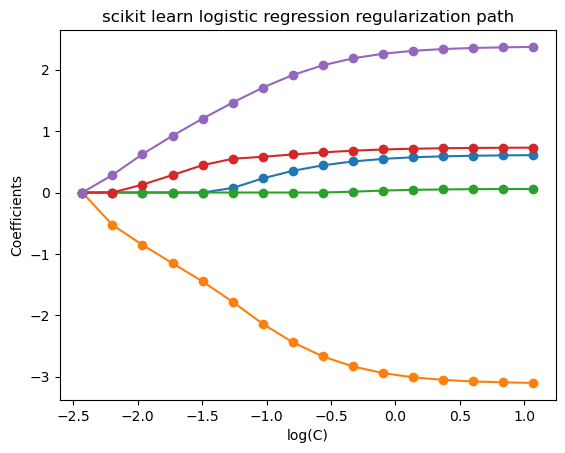

In [4]:
plt.plot(np.log10(skl_path["c"]), skl_path[["x0", "x1", "x2", "x3", "x4"]], marker="o")
ymin, ymax = plt.ylim()
plt.xlabel("log(C)")
plt.ylabel("Coefficients")
plt.title("scikit learn logistic regression regularization path")
plt.axis("tight")
plt.show()

Fit the regularization path using our implementation of regularized logistic regression with cross-entropy and mean-net-benefit maximizing loss functions.

In [5]:
# Set this variabe to decide whether to load the previously run picked version or recalculate
load_pickled_version = True

if load_pickled_version:
    with open('../data/reg_paths.pkl', 'rb') as f:
        [torch_log_path, torch_mnb_path] = pickle.load(f)
else:

        torch_log_path = dcafs.reg_path(df_train, 
                                        df_test, 

                                        history_size = 200, 
                                        max_iter = 20000, 
                                        tolerance_grad=1e-18, 
                                        tolerance_change=1e-18,

                                        n_epochs = 20000,
                                        learn_rate = 10.0,

                                        loss_fun = "log", 
                                        log_space_min = 0,
                                        log_space_max = 3.5,
                                        log_space_steps = 16,
                                        
                                        grad_max_norm = 0.0001)
        
        torch_mnb_path = dcafs.reg_path(df_train, 
                                        df_test, 
                                        history_size = 100, 
                                        max_iter = 20000, 
                                        tolerance_grad=1e-18, 
                                        tolerance_change=1e-18,

                                        n_epochs = 10000,
                                        learn_rate = 10.0,

                                        loss_fun = "mnb", 
                                        test_harms=None,
                                        log_space_min = 0,
                                        log_space_max = 3.5,
                                        log_space_steps = 16)
        


        with open('../data/reg_paths.pkl', 'wb') as f:
                pickle.dump([torch_log_path, torch_mnb_path], f)

Fit the regularization path with mean-net-benefit maximizing loss function and test-harm weighted LASSO.

We choose test harms (in true positive benefit units) as:

In [6]:
test_harms = {"x0": 0.0, "x1": 0.015, "x2": 0.03, "x3": 0.045, "x4": 0.06 }

In [7]:
# Set this variabe to decide whether to load the previously run picked version or recalculate
load_pickled_version = True

if load_pickled_version:
    with open('../data/reg_path_harm.pkl', 'rb') as f:
        [torch_mnb_path_with_harm] = pickle.load(f)
else:


        torch_mnb_path_with_harm = dcafs.reg_path(df_train, 
                                        df_test, #

                                        history_size = 100, 
                                        max_iter = 20000, 
                                        tolerance_grad=1e-18, 
                                        tolerance_change=1e-18,

                                        n_epochs = 10000,
                                        learn_rate = 10.0,
                                        loss_fun = "mnb", 
#                                        test_harms=[0.0,0.1,0.2,0.3,0.4],
                                        test_harms=list(test_harms.values()),
                                        log_space_min = 0,
                                        log_space_max = 3.5,
                                        log_space_steps = 16)


        with open('../data/reg_path_harm.pkl', 'wb') as f:
                pickle.dump([torch_mnb_path_with_harm], f)

We examine the regularization paths and note that :

* The regularization paths are broadly similar between the three 

* The pytorch implementation seems to be less numerically stable than the scikit learn implementation as there are some irregularities

* Including the feature cost test changes the point at which coefficients drop to zero and fall out of the model.

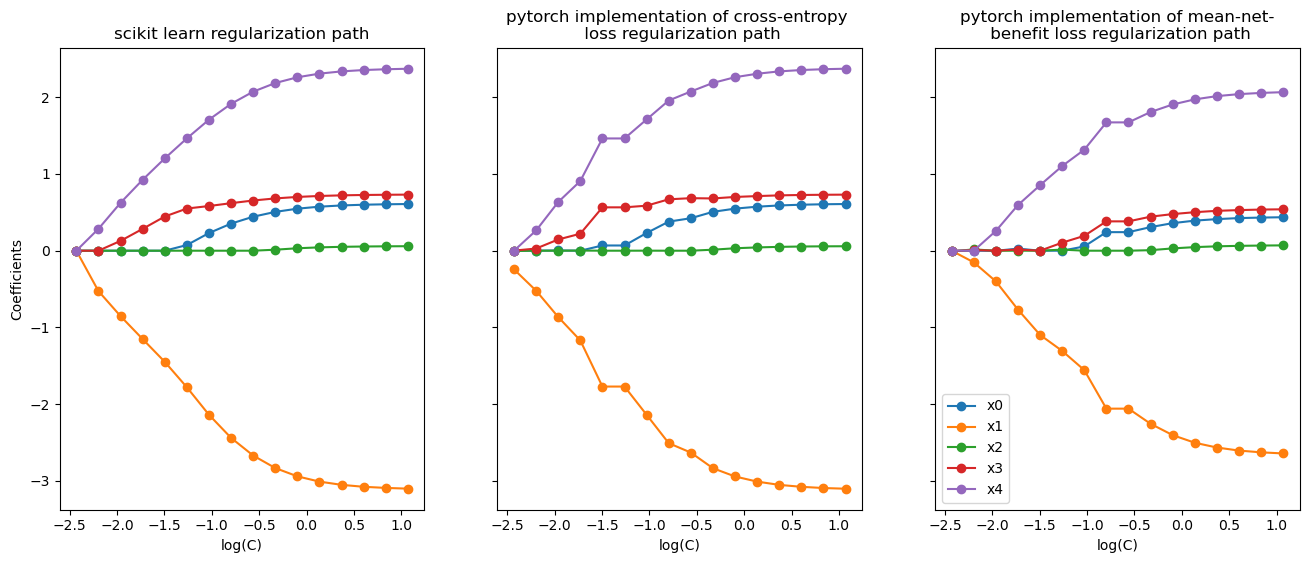

In [8]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(16, 6))

for v in ["x0", "x1", "x2", "x3", "x4"]:
    #ax1.plot(np.log10(skl_path["c"]), skl_path[["x0", "x1", "x2", "x3", "x4"]], marker="o")
    ax1.plot(np.log10(skl_path["c"]), skl_path[[v]], marker="o", label=v)
    ax2.plot(np.log10(torch_log_path["path"]["c"]), torch_log_path["path"][[v]], marker="o", label = v)
    ax3.plot(np.log10(torch_mnb_path_with_harm["path"]["c"]), torch_mnb_path_with_harm["path"][[v]], marker="o", label=v)

ax1.set_xlabel("log(C)")
ax1.set_ylabel("Coefficients")
ax1.set_title("scikit learn regularization path")
ax1.axis("tight")

ax3.legend(loc='lower left')
#ax2.legend(loc='upper left')
#ax3.legend(loc='upper left')

ax2.set_xlabel("log(C)")
ax2.set_title("pytorch implementation of cross-entropy \n loss regularization path")

ax3.set_xlabel("log(C)")
ax3.set_title("pytorch implementation of mean-net-\n benefit loss regularization path")

fig.show()

Below we define a function that draws a threshold clipping the coefficients to zero if they fall within a given fraction of their initial (small penalty) values.

In [9]:
def plot_nb_prep(df_in, harms, independent, dependent = "y", coef_clip_frac = 0.001):

    # Apply cliping threshold for the coefficents

    t0 = df_in.sort_values("c", ascending=False).iloc[[0]][independent].abs()
    df = df_in.copy()


    t0 = t0.copy()*coef_clip_frac

    for v in t0.columns:

        #clip the coefficients
        b = (df[v].abs() <= float(t0[v].iloc[0]))
        df.loc[b, v ] = 0.

        # make coefficients zero after first zero
        c_first_zero = df[df[v] == 0].head(1).loc[:, "c"]
        b = (df["c"] <= float(c_first_zero.iloc[0]))
        df.loc[b, v ] = 0.

    # indicate which coefficients are being used along the regularization path

    for iv in independent:

        df.loc[:, iv+"_used"] = [np.heaviside(i, 0) for i in df.loc[:, iv].abs()]

    # indicate the number of coefs used and
    # include test harm in mean net benefit
    used_cols = [iv+"_used" for iv in independent]

    df["harm"] =  df[used_cols].mul(harms).sum(1)
    df["mnb"] = df["mnb0"]-df["harm"]

    df["n_coefs"] = df[used_cols].sum(1)

    # identify maximum mnb
    # ---------------------
    optim_row = df['mnb'].idxmax()
    optim = df.iloc[optim_row]

    return {'df': df, 'independent': independent, 'dependent': dependent, 'optimal': optim}
    

Use the above function to evaluate the mean net benefit along the regularisation path.

In [10]:
selection_path = plot_nb_prep(torch_mnb_path_with_harm["path"], list(test_harms.values()), ["x0", "x1", "x2", "x3", "x4"])

# Save for later comparison to other methods

with open('../data/selection_path_.pkl', 'wb') as f:
    pickle.dump(selection_path, f)

selection_path['df']


,c,lambda,label,mnb0,harm,mnb,n_coefs,x0,x1,x2,x3,x4,x0_used,x1_used,x2_used,x3_used,x4_used
0,11.746387,0.000106,reg_path,0.292942,0.150,0.142942,5.0,0.436293,-2.642572,0.069590,0.539597,2.066512,1.0,1.0,1.0,1.0,1.0
1,6.863900,0.000182,reg_path,0.293676,0.150,0.143676,5.0,0.431882,-2.628051,0.067172,0.536440,2.056643,1.0,1.0,1.0,1.0,1.0
2,4.010861,0.000312,reg_path,0.294029,0.150,0.144029,5.0,0.425122,-2.605027,0.063395,0.529108,2.040857,1.0,1.0,1.0,1.0,1.0
3,2.343712,0.000533,reg_path,0.293611,0.150,0.143611,5.0,0.411778,-2.565311,0.057138,0.519836,2.014910,1.0,1.0,1.0,1.0,1.0
4,1.369528,0.000913,reg_path,0.292450,0.150,0.142450,5.0,0.391996,-2.503005,0.046756,0.501974,1.972479,1.0,1.0,1.0,1.0,1.0
5,0.800272,0.001562,reg_path,0.292301,0.150,0.142301,5.0,0.359245,-2.403783,0.030014,0.477271,1.905844,1.0,1.0,1.0,1.0,1.0
6,0.467632,0.002673,reg_path,0.296030,0.150,0.146030,5.0,0.307718,-2.256043,0.006899,0.443621,1.807680,1.0,1.0,1.0,1.0,1.0
7,0.273257,0.004574,reg_path,0.294699,0.120,0.174699,4.0,0.241871,-2.058593,0.000000,0.382439,1.672578,1.0,1.0,0.0,1.0,1.0
8,0.159675,0.007828,reg_path,0.294699,0.120,0.174699,4.0,0.241871,-2.058593,0.000000,0.382439,1.672578,1.0,1.0,0.0,1.0,1.0
9,0.093305,0.013397,reg_path,0.287420,0.120,0.167420,4.0,0.055511,-1.555763,0.000000,0.193626,1.316423,1.0,1.0,0.0,1.0,1.0


Define finctions for plotting the mean-net benefit and number of features along the regularization path:

In [11]:
def plot_nb_path(prep_dict, ax):
    for v in prep_dict['independent']:
        ax.plot(np.log10(prep_dict['df']["c"]), prep_dict['df'][v], marker="o", label= v)
    ax.legend(loc = "lower right")

def plot_mnb_path(prep_dict, ax):
    ax.plot(np.log10(prep_dict['df']["c"]), prep_dict['df'][['mnb']], marker="o")

def plot_nfeatures_path(prep_dict, ax):
    ax.step(np.log10(prep_dict['df']["c"]), prep_dict['df'][['n_coefs']], marker="o")

Plot the selection path:

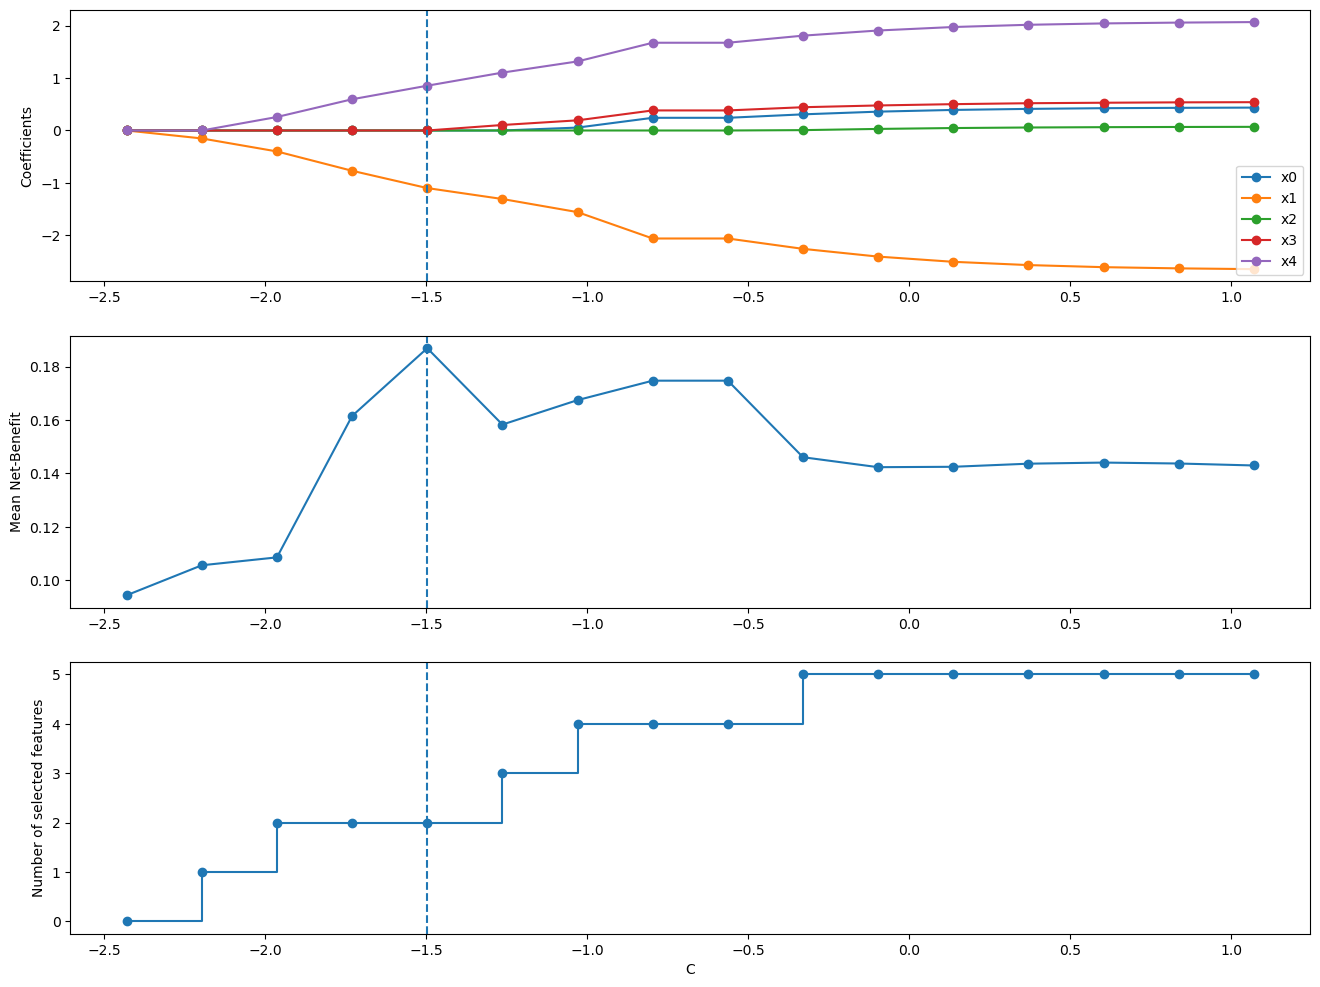

In [12]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharey=False, figsize=(16, 12))
plot_nb_path(selection_path, ax1)
plot_mnb_path(selection_path, ax2)
plot_nfeatures_path(selection_path, ax3)

ax1.axvline(x = np.log10(selection_path['optimal']['c']), linestyle = '--')
ax2.axvline(x = np.log10(selection_path['optimal']['c']), linestyle = '--')
ax3.axvline(x = np.log10(selection_path['optimal']['c']), linestyle = '--')

ax1.set_ylabel("Coefficients")
ax2.set_ylabel("Mean Net-Benefit")
ax3.set_ylabel("Number of selected features")

ax3.set_xlabel("C")

#ax1.legend(ax1.patches, selection_path['independent'], loc='upper left')
plt.show()

### Conclusion

The pytorch implementation of cross-entropy and mean-net-benefit maximizing loss versions of logistic regression are similar to the scikit learn benchmark although there is a degree of numerical instability.

Along the rgularization path with mean-net-benefit maximizing loss and test harm weighted penalty the maximum net benefit occurs with features $\{x_1, x_4 \}$ selected as these are the only non-zero coefficients at that point.